In [14]:
import os
import pandas as pd

import numpy as np
from numpy import exp
from numpy import log
from numpy import sqrt
from numpy import power
import matplotlib.pyplot as plt

import scipy
from scipy import special

import math
from math import pi
from math import erf
from math import erfc

os.getcwd()


'/content'

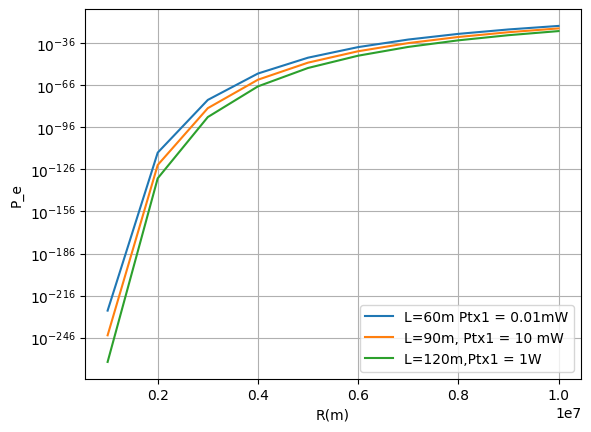

Threshold_opt 0.9945003958040073
Numr_trm0 0.6287575174225815
116173619.07636581


In [24]:
import datetime

PDE=0.24 #photo detection efficiency%3mm Sensor 20um - 30020, overvoltage @ 2.5V
lamda=450e-9#Wavelength of Blue light
A=0.0044 #SiPM surface area
G=1e6


pap=0.002 #probability of afterpulsing
pct=0.0003 #probability of crosstalk
dCR=6.6e6 #dark count rate6.6*10^6
c=2.25e8
hp=6.626e-34  # Planck's constant h,
e=1.6e-19  # Charge of Electron
Nspad=10998 # %number of SPAD (microcells)
td= 100e-9  # %tau_d deadtimex

Pac=1+pap+pct #% probability of current
Res=PDE*lamda*G*e*Pac/(hp*c)  # what? % SiPM responsitivity
Fe=1.1  # funtion of the doping profile

# %Laser Diode Parameters

ext=0.4 #%extinction ratio
# % Ptx1=0.002 # %power of bit 1 in watt
# % Ptx0=ext*Ptx1 #%0.0008  %power of bit 0 in watt
Ptx = [0.0001,0.01,1]
ce=0.151 #%diffuse coefficient of attenuation for clear waters
Rb1 = np.linspace(1, 10, num=10, endpoint=True, retstep=False, dtype=None)*1e6
Zb = [60,90,120]# link range
L_Zb = len(Zb)
# L_Rb = len(Rb)

for i in range(L_Zb):
  Z = Zb[i]
  Ptx1=Ptx[i] # %power of bit 1 in watt
  Ptx0=ext*Ptx1#三个长度，三个能量强度
  Avg_BER1 = []#
  for Rb in Rb1:
    # Rb=1*1e6
    # Rb = Rb[b] # choose the bit rate
    # Z=Zb(b) %%choose the range
      # %% path loss
    Lch=math.exp(-ce*Z) #%channel loss%diffuse coefficient ce
    h_L=Lch # channel loss factor

## %% Turbulence
    lenth=int(1e7)#%%length of the signal
    muuT=-0.3516# %% mean of log-amplitude coefﬁcient of turbulence
    # sigmaaT=0.8386# %%variance of log-amplitude coefﬁcient of turbulence
    SigmaaTT = [0.7032,0.9872,1.21]
    sigmaaT = SigmaaTT[i]

    gen_Norm_numbers_YT=np.random.normal(muuT, sigmaaT, [lenth,1])

    h_T1=np.exp(gen_Norm_numbers_YT)
    h_T=h_T1#Turbulence factor,Its a distribution
    ## pointing errors

    sigma_rp = 0.2 #linspace(0.2,2,10) %(1:1:10)*1e-1
#  %%variance of radial displacement of the transmitted beam spot at L for the
#  %center fo the Rx lens
    # Ray_dist = makedist('Rayleigh','B',sigma_rp)
    r_p = np.random.rayleigh(sigma_rp,[lenth,1])
    # r_p=random(Ray_dist,[1,lenth])  %
    A_apr = A#%A  %pi*r_apr**2 Pi*r^2 %Area of lens %SiPM surface area
    r_apr = np.sqrt(A_apr/math.pi)#radius of lens
    D_apr = 2*r_apr #diameters of lens

    div_angle = 8.726646e-5 #divergence angle
    w_z=div_angle*Z # approximation of beam width

    v_sm=(np.sqrt(pi)*r_apr)/(np.sqrt(2)*w_z) # variables

    A_0 = np.power((erf(v_sm)),2) #factor at no pointing error

    w_zeq2 = (w_z**2*np.sqrt(pi)*erf(v_sm))/(2*v_sm*exp(-v_sm**2)) #equivalent beam width

    h_P = A_0*np.exp((-2*power(r_p,2))/w_zeq2) #pointing error facor

    # %% total channel gain

    h_gain = h_L#*h_T# %*h_P - no pointing error
# %% noise
    # %%bandwith
    Br=Rb/2#%1e7 % receiver low-pass filter Bandwidth / bandwidth of the receiver low-pass filter Be=1e9  %PD bandwidth (in Hz)(Electrical bandwidth)/ bandwidth of the receiver low-pass filter
    RL=1000 # %load resistor of TIA ohms
    K=1.38064852e-23# % boltzman constant (m2 kg s-2 K-1)
    Te=300 # equivqlent noise temperature [K]
    sgmath2=4*K*Te*Br/RL #%thermal noise variance

    Bo=2e-9 #Optical 'filter' bandwidth  at the Rx
    Esun_lamda_0=0.2/(1e-9) #Spectral radiance of the background radiations
    tw=0.97 #water transmittance h_prime 0.95

    Kd=0.08 #diffuse coefficient of attenuation for clear waters
    h_Lb=exp(-Kd*Z) #channel loss
    # print(h_Lb)
    #muu = 0
    #theta_FOVr = 0.07 #4 deg. = 0.07rad,  1 rad = 60 deg
    #Pb=Esun_lamda_0*h_Lb*tw*Bo*A_apr*pi*theta_FOVr**22 # background power
    I_b = 0 #no solar noise %Res*Pb*RL
    sigma2_b = 0  #no solar noise %2*e*G*Fe*Br*I_b*RL

# %%%%%%%%%%%%%%Considering Optimal Threshold for an SiPM Output Photocurrent%%%%%%%%%%%%%%%
    Is_1msm1=Res*Ptx1*RL

    I_d=dCR*Pac*G*e*RL

    Is_0msm0=ext*Is_1msm1

    coeff=2*e*G*Fe*Br

    sgma2_d=coeff*I_d

    sgma2_dth=sgma2_d*RL + sgmath2

    sgma2_1sm1=coeff*Is_1msm1*RL

    sgma2_0sm0=coeff*Is_0msm0*RL
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% BER %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    Threshold_opt = ((((Is_0msm0*h_gain)+ I_d + I_b)*
     (sgma2_1sm1*h_gain + sgma2_dth + sigma2_b)-((Is_1msm1*h_gain)+ I_d + I_b)*(sgma2_0sm0*h_gain + sgma2_dth + sigma2_b))/
      ((sgma2_1sm1*h_gain + sgma2_dth + sigma2_b)-(sgma2_0sm0*h_gain + sgma2_dth + sigma2_b))+sqrt((((Is_0msm0*h_gain+ I_d + I_b)*
       (sgma2_1sm1*h_gain+ sgma2_dth + sigma2_b)-(Is_1msm1*h_gain+ I_d + I_b)*
        (sgma2_0sm0*h_gain + sgma2_dth + sigma2_b))/((sgma2_1sm1*h_gain + sgma2_dth + sigma2_b)-(sgma2_0sm0*h_gain +sgma2_dth + sigma2_b)))**2+(((Is_1msm1*h_gain)+ I_d + I_b)**2*
         (sgma2_0sm0*h_gain + sgma2_dth + sigma2_b)-
          ((Is_0msm0*h_gain)+ I_d + I_b)**2*(sgma2_1sm1*h_gain +sgma2_dth + sigma2_b))/((sgma2_1sm1*h_gain + sgma2_dth + sigma2_b)-
           (sgma2_0sm0*h_gain + sgma2_dth + sigma2_b))-(((sgma2_0sm0*h_gain + sgma2_dth + sigma2_b)*(sgma2_1sm1*h_gain +
           sgma2_dth + sigma2_b))/((sgma2_1sm1*h_gain + sgma2_dth + sigma2_b)-(sgma2_0sm0*h_gain + sgma2_dth + sigma2_b)))*
            (log((sgma2_0sm0*h_gain + sgma2_dth + sigma2_b)/(sgma2_1sm1*h_gain + sgma2_dth + sigma2_b)))))
    Numr_trm1 = (Is_1msm1*h_gain)+ I_d + I_b#%nurmical simulated current of bit 1

    Denm_trm1 =  sqrt(2*((sgma2_1sm1*h_gain) + sgma2_dth + sigma2_b))

    Numr_trm0 = (Is_0msm0*h_gain)+ I_d + I_b

    Denm_trm0 =  sqrt(2*((sgma2_0sm0*h_gain) + sgma2_dth + sigma2_b))

    Avg_BER_Inst =  0.25*special.erfc(((Threshold_opt - Numr_trm0)/Denm_trm0)) +0.25*special.erfc(((Numr_trm1 - Threshold_opt)/Denm_trm1))

    Avg_BER1.append(np.mean(Avg_BER_Inst))
    # legends()
  labels = ["L=60m Ptx1 = 0.01mW","L=90m, Ptx1 = 10 mW","L=120m,Ptx1 = 1W"]

  plt.semilogy(Rb1,Avg_BER1,label=labels[i])  # 对 result 取 log 后画线
  plt.xlabel("R(m)")
  plt.ylabel("P_e")
  # plt.title("log-line")
plt.legend()
plt.grid(True)  # 显示网格线
plt.show()

# print("Avg_BER_Inst",Avg_BER_Inst)
print("Threshold_opt",Threshold_opt)
print("Numr_trm0",Numr_trm0)
# print("Denm_trm0",Denm_trm0)

print(Is_1msm1)


In [23]:

print("Numr_trm0",Numr_trm0)
print("Threshold_opt",Threshold_opt)
print("Numr_trm1",Numr_trm1)

Threshold_opt 0.9945003958040073
Numr_trm0 0.6287575174225815
Numr_trm1 1.5703061503564537


In [19]:
print(Res)
print("Is_0msm0",Is_0msm0)
print("h_gain",h_gain)
print("h_T",h_T)
print(sgma2_1sm1)
print(sgma2_1sm1*h_gain + sgma2_dth + sigma2_b)
print(h_L)

116173.61907636581
Is_0msm0 46469447.63054633
h_gain [[8.60125798e-09]
 [9.00399598e-08]
 [3.52846836e-09]
 ...
 [1.21877891e-07]
 [3.83970417e-08]
 [1.18524302e-08]]
h_T [[0.63676324]
 [6.66578504]
 [0.26121748]
 ...
 [9.02279197]
 [2.84258708]
 [0.8774521 ]]
204465.56957440384
[[0.00176052]
 [0.01841193]
 [0.00072331]
 ...
 [0.0249217 ]
 [0.00785274]
 [0.00242528]]
1.3507780286373975e-08


In [ ]:
#test pint parameters
# print(dCR)
# print(Res,Rb)
# print(len(gen_Norm_numbers_YT))
# print(len(h_T))
# print(len(r_p))
# print(gen_Norm_numbers_YT)
# print(v_sm)
a = [1,2,2,3]
power(a,2)
print(len(h_P))
b=[]
print(Rb.T)

10000000
10000000.0


In [ ]:
for i in Rb1:
  for n in range(100):
  # print(i)
   b.append(1)

print(len(b))

2000
